# Analysis of behavioral drift though a logistic regression approach 

__1. Define set of behavioral regressors__

    "Bad Behavior"
    1. Velocity
    2. Position on patch  
    
    "Uninteresting Behavior"
    3. Reward size 
    4. Time on patch  
    
    "Good Behavior"
    5. Number of Rews  
    6. total uL received
    7. Time since reward 

__2. Fit logistic regression models to a sliding window of ~50 trials__
 - Ensure that fits are roughly equally good at all time windows w/ xval metrics? 

__3. Analyze drift in logistic regression model coefficients across session__ 
- Are there discrete or slow changes in model fits that consistently vary across session? 
- Use Kalman filter to estimate gaussian walk if seems smooth 
- Assumption: changes in behavior are slow and consistent between reward sizes
    - Alternatively, could fit model coefficients per reward size 
    - But this will not be a good model of single trial lapses in performance

In [1]:
# standard stuff
import numpy as np  
import random
import scipy.io as sio  
import os 
import matplotlib.pyplot as plt 
import seaborn as sns   
import pandas as pd    
from scipy.stats import zscore
# sklearn stuff
from sklearn import metrics  
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression

## Prepare Datasets

In [2]:
# load all datasets into dictionary
mouse_dir = '/Users/joshstern/Documents/UchidaLab_NeuralData/processed_neuropix_data/all_mice'   
data = dict()

with os.scandir(mouse_dir) as it:
    for entry in it:
        if not entry.name.startswith('.') and entry.is_file():
            data[entry.name[:2] + entry.name[-7:-4]] = sio.loadmat(entry.path) 
            print("Finished loading %s"%entry.name)


Finished loading 79_20200225.mat
Finished loading 76_20200305.mat
Finished loading 79_20200226.mat
Finished loading 76_20200306.mat
Finished loading 76_20200307.mat
Finished loading 79_20200227.mat
Finished loading 76_20200303.mat
Finished loading 76_20200302.mat
Finished loading 80_20200315.mat
Finished loading 80_20200317.mat
Finished loading 79_20200304.mat
Finished loading 79_20200305.mat
Finished loading 80_20200316.mat
Finished loading 78_20200312.mat
Finished loading 78_20200313.mat
Finished loading 78_20200311.mat
Finished loading 79_20200302.mat
Finished loading 79_20200303.mat
Finished loading 78_20200310.mat
Finished loading 75_20200313.mat
Finished loading 79_20200229.mat
Finished loading 76_20200309.mat
Finished loading 75_20200315.mat
Finished loading 76_20200308.mat
Finished loading 79_20200228.mat


In [35]:
flatten = lambda l: [item for sublist in l for item in sublist] 

# superclass 
class Dataset():
    def __init__(self,data,t1,t2): 
        self.t1 = t1 
        self.t2 = t2  
        self.data = data 
        
    def t1_t2(self): 
        print("t1: %i \t t2: %i" % (self.t1,self.t2)) 
        
    def gen_trialedDataset(self,data): 
        """  
            Arguments 
                data: dataset from one session

            Returns
                X_trials: array of nTrials matrices of taskvars 
                    Velocity 
                    Position on patch 
                    Rewsize 
                    Time on Patch 
                    # Rewards 
                    Total uL 
                    Time since reward 
                y_trials: array of nTrials vectors of preLeave labels
        """   
        # timebin
        tbin_ms = 1000 * data['velt'][0][1] - data['velt'][0][0]     
        dt = tbin_ms / 1000

        # labeling settings
        labeling_ms = self.t2 - self.t1  
        labeling_ix = int(round(labeling_ms / tbin_ms))
        pre_leave_buffer_ms = self.t1 # ms before leave to exclude in analysis of neural data  
#         pre_rew_buffer_ms = labeling_ms + pre_leave_buffer_ms # = t2; msec to exclude preceding reward 
        pre_rew_buffer_ix = int(round(self.t2 / tbin_ms)) # ix to exclude preceding reward  

        # session timing timing information
        patchCSL = data['patchCSL'] 
        rewsizes = data['patches'][:,1] % 10
        nTrials = patchCSL.shape[0]
        patchcue_ms = patchCSL[:,0] * 1000 
        patchstop_ms = patchCSL[:,1] * 1000   
        patchleave_ms = patchCSL[:,2] * 1000  
        prts = patchleave_ms - patchstop_ms 
        rew_ms = data['rew_ts'] * 1000  
        # create index vectors from our timing information vector and labeling settings
        patchstop_ix = np.round(patchstop_ms / tbin_ms).astype(int)
        patchleave_ix = np.round((patchleave_ms - pre_leave_buffer_ms) / tbin_ms).astype(int) 
        
        # Collect behavioral variables
        vel_trials = [data['vel'][0][patchstop_ix[iTrial]:patchleave_ix[iTrial]] for iTrial in range(nTrials)]
        pos_trials = [data['patch_pos'][0][patchstop_ix[iTrial]:patchleave_ix[iTrial]] for iTrial in range(nTrials)]
        t_lens = [len(v) for v in vel_trials]  
        round_prts = np.array(t_lens) * tbin_ms / 1000 # prt rounded to nearest dt  
        
        # Collect task variables and combine w/ behavioral variables
        X_trials = [] # task variables put together in an array 
        y_trials = [] # label data as on patch or leave patch 
        X_trials_noPreRew = [] # task variables put together in an array , no preRew data
        y_trials_noPreRew = [] # label data as on patch or leave patch , no preRew data 
        for iTrial in range(nTrials): 
            # get the reward timing for this trial (excludes t = 0 reward)
            rew_indices = np.round((rew_ms[(rew_ms > patchstop_ms[iTrial]) & (rew_ms < patchleave_ms[iTrial])] - patchstop_ms[iTrial]) / 1000)
            
            # time on patch ... and handling of off-by-one errors
            if len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial]:
                tr_timeOnPatch = np.arange(0,round_prts[iTrial],dt) 
            elif len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial] + 1:   
                if len(np.arange(0,round_prts[iTrial]-dt,dt)) == t_lens[iTrial]: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]-dt,dt)  
                else: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]-dt/2,dt)  
            elif len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial] - 1: 
                if len(np.arange(0,round_prts[iTrial]+dt,dt)) == t_lens[iTrial]: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]+dt,dt)  
                else: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]+dt/2,dt)   
            else: 
                print("We are off by more than one in indexing somehow") 

            # some reward-related signals 
            tr_rewsize = np.full(len(tr_timeOnPatch),rewsizes[iTrial]) 
            tr_timesince = tr_timeOnPatch.copy()
            tr_rewCount = np.zeros(len(tr_timeOnPatch))
            tr_uLtotal = np.zeros(len(tr_timeOnPatch)) 
            pre_rew_label = np.zeros(t_lens[iTrial])  
            for i,rew_sec in enumerate(rew_indices):    
                # add to timesince 
                irew_ix = int(round(rew_sec * 1000 /tbin_ms))  
                irew_msec = rew_sec * 1000
                try:
                    tr_timesince[irew_ix:] = np.arange(0,round_prts[iTrial]-rew_sec,dt)     
                except:   
                    tr_timesince[irew_ix:] = np.arange(0,round_prts[iTrial]-rew_sec-dt/2,dt)  

                # update reward and uL count
                tr_rewCount[irew_ix:] = i + 1 
                tr_uLtotal[irew_ix:] = (i + 1) * rewsizes[iTrial]  
                
                # label points right before reward to improve classification fidelity
                pre_rew_label[(irew_ix - pre_rew_buffer_ix):irew_ix] = 1 # label for removal

            # Pre-reward indices
            non_pre_rew = np.where(pre_rew_label == 0)[0]  
            
            tr_X = np.concatenate((vel_trials[iTrial][:,np.newaxis],
                                   pos_trials[iTrial][:,np.newaxis],
                                   tr_timeOnPatch[:,np.newaxis], 
                                   tr_rewsize[:,np.newaxis],
                                   tr_timesince[:,np.newaxis],
                                   tr_rewCount[:,np.newaxis],
                                   tr_uLtotal[:,np.newaxis]),axis = 1)  
            X_trials.append(tr_X) 

            tr_X_noPreRew = np.concatenate((vel_trials[iTrial][non_pre_rew][:,np.newaxis],
                                            pos_trials[iTrial][non_pre_rew][:,np.newaxis],
                                            tr_timeOnPatch[non_pre_rew][:,np.newaxis], 
                                            tr_rewsize[non_pre_rew][:,np.newaxis],
                                            tr_timesince[non_pre_rew][:,np.newaxis],
                                            tr_rewCount[non_pre_rew][:,np.newaxis],
                                            tr_uLtotal[non_pre_rew][:,np.newaxis]),axis = 1)   
            X_trials_noPreRew.append(tr_X_noPreRew)
            tr_y = np.concatenate((np.zeros(max(0,t_lens[iTrial] - labeling_ix)),np.ones(labeling_ix))) 
            tr_y_noPreRew = tr_y[non_pre_rew]  
            y_trials.append(tr_y)
            y_trials_noPreRew.append(tr_y_noPreRew) 
            
        return X_trials,y_trials,X_trials_noPreRew,y_trials_noPreRew  
    
    def train_val_split(self,X_trials,y_trials,rewsizes):  
        """ 
            Function to split training and validation data 
            On all trials or a subset of trials
        """ 
        tmp_nTrials = len(y_trials)
        
        # vector with every index labeled by its trial number
        trial_ix = np.array(flatten([[iTrial] * len(y_trials[iTrial]) for iTrial in range(tmp_nTrials)]))
        # allocate training and validation trials 
        train_trials = [] 
        val_trials = []
        for rewsize in [1,2,4]: 
            iRewsize_trials = np.where(rewsizes == rewsize)[0]  
            i_train_trials = random.sample(list(iRewsize_trials),k = int(self.prop_val*len(iRewsize_trials)))  
            i_val_trials = np.setdiff1d(iRewsize_trials,i_train_trials)
            train_trials.append(i_train_trials) 
            val_trials.append(i_val_trials.tolist())   
        # flatten our lists of lists to make list of trials
        train_trials = np.array(flatten(train_trials))
        val_trials = np.array(flatten(val_trials)) 
        train_ix = np.where(np.isin(trial_ix,train_trials)) 
        val_ix = np.where(np.isin(trial_ix,val_trials)) 
        # convert to size of train trials
        train_trial_ix = trial_ix[train_ix]
        
        # Now turn separated data into arrays
        X_train = np.concatenate([X_trials[trial] for trial in train_trials])
        y_train = np.concatenate([y_trials[trial] for trial in train_trials])
        X_val = np.concatenate([X_trials[trial] for trial in val_trials]) 
        y_val = np.concatenate([y_trials[trial] for trial in val_trials])  
        
        # Now divide training data into k folds, first at the trial level
        trial_folds = np.empty(tmp_nTrials) 
        trial_folds[:] = np.nan 
        trial_folds[val_trials] = -1 # set aside the validation trials 
        for shift,iRewsize in enumerate(np.unique(self.rewsizes)):  
            iRewsize_train_trials = train_trials[np.where(rewsizes[np.array(train_trials)] == iRewsize)] 
            iRewsize_folds = np.tile(range(self.k),tmp_nTrials)[:len(iRewsize_train_trials)] 
            iRewsize_folds = (iRewsize_folds + shift*len(np.unique(rewsizes))) % (self.k) # shift s.t. we don't skimp on the last fold
            trial_folds[iRewsize_train_trials] = iRewsize_folds 
        self.trial_folds = trial_folds

        # Now turn our trials into k length list of [(train_index, test_index)]   
        kfold_split = []
        for test_fold in range(self.k):   
            fold_train_trials = np.where((self.trial_folds >= 0) & (self.trial_folds != test_fold))[0]
            fold_test_trials = np.where(self.trial_folds == test_fold)[0] 
            fold_train_ix = np.where(np.isin(train_trial_ix,fold_train_trials))[0] 
            fold_test_ix = np.where(np.isin(train_trial_ix,fold_test_trials))[0] 
            kfold_split.append((fold_train_ix,fold_test_ix))  
        
        return (X_train,y_train,kfold_split,X_val,y_val)
    
    def fit_model(self,model): 
        """
            Train an Sklearn classification model and trialed X and y data  
            
            Arguments: 
                X_trialed (Potentially for some range of trials) 
                y_trialed (Potentially for some range of trials)
            
            Returns: 
                fitted model 
                evaluation metrics dictionary
        """   
        

        raise NotImplemented
    
    def fit_logReg_cv(self,X,y,kfold_split): 
        """
            Train an Sklearn classification model and trialed X and y data  
            
            Arguments:  
                X_trialed (Potentially for some range of trials) 
                y_trialed (Potentially for some range of trials) 
                kfold_split: kfold xval index tuples
            
            Returns: 
                fitted model 
                evaluation metrics dictionary
        """   
        # initialize logging structures
        roc_results = pd.DataFrame(columns = ["threshold","fpr","tpr"],dtype = np.float64)
        pr_results = pd.DataFrame(columns = ["threshold","precision","recall"],dtype = np.float64) 
        auc = np.empty(self.k) 
        auc[:] = np.nan 
        ap = np.empty(self.k) 
        ap[:] = np.nan  
        coeffs = np.empty((self.k,X.shape[1]))
        coeffs[:] = np.nan

        for f,(train_index, test_index) in enumerate(kfold_split):    
            # make new logreg pipeline
            model = make_pipeline(StandardScaler(), LogisticRegression(solver = 'saga',penalty = 'elasticnet',l1_ratio = .1)) 
            
            # split up by fold
            fold_X_train, fold_X_test = X[train_index], X[test_index]
            fold_y_train, fold_y_test = y[train_index], y[test_index]  

            # train models on their different datasets
            model = model.fit(fold_X_train, fold_y_train) 

            # predict on test and evaluate
            pred_prob = model.predict_proba(fold_X_test)  
            fpr,tpr,thresholds_roc = metrics.roc_curve(fold_y_test,pred_prob[:,1])  
            auc[f] = metrics.roc_auc_score(fold_y_test,pred_prob[:,1])   
            precision,recall,thresholds_pr = metrics.precision_recall_curve(fold_y_test,pred_prob[:,1]) 
            ap[f] = metrics.average_precision_score(fold_y_test,pred_prob[:,1])  

            # log results  
            roc_data = np.array([np.round(thresholds_roc,1),np.round(fpr,2),tpr]) 
            roc_df = pd.DataFrame(roc_data.T,columns = ["threshold","fpr","tpr"]) 
            roc_df[["threshold","fpr","tpr"]] = roc_df[["threshold","fpr","tpr"]].astype(np.float64)
            roc_results = roc_results.append(roc_df) 

            pr_data = np.array([np.round(thresholds_pr,1),np.round(precision[1:],2),recall[1:]]) 
            pr_df = pd.DataFrame(pr_data.T,columns = ["threshold","precision","recall"]) 
            pr_df[["threshold","precision","recall"]] = pr_df[["threshold","precision","recall"]].astype(np.float64)
            pr_results = pr_results.append(pr_df) 
            
            coeffs[f,:] = model[1].coef_[0]
        
        metrics_dict = dict(auc = auc, 
                            ap = ap,
                            roc_results = roc_results,
                            pr_results = pr_results)
        
        return coeffs,metrics_dict
    
    def dropout_test(self,model): 
        raise NotImplemented 

class MouseDataset(Dataset): 
    def __init__(self,data,mouse,t1,t2): 
        self.t1 = t1 
        self.t2 = t2
        
        mouse_days = [day for day in list(data.keys()) if mouse in day] # find all mouse days 
        sorted_mouse_days = list(map(str,np.sort([int(day) for day in mouse_days]))) 
        self.data = {mouse_day: data[mouse_day] for mouse_day in sorted_mouse_days} # subselect mouse data 
        tbin_ms = self.data[mouse_days[0]]['velt'][0][1] - self.data[mouse_days[0]]['velt'][0][0]
        
class SessionDataset(Dataset): 
    def __init__(self,data,day,t1,t2,k = 5,prop_val = 0.9): 
        self.t1 = t1 # in msec
        self.t2 = t2  
        self.data = data[day] # subselect session data     
        self.rewsizes = self.data['patches'][:,1] % 10 
        self.nTrials = len(self.rewsizes) 
        self.k = k 
        self.prop_val = prop_val
        
        # make classification dataset
        (self.X_trials,
         self.y_trials, 
         self.X_trials_noPreRew, 
         self.y_trials_noPreRew) = self.gen_trialedDataset(self.data)    
        
        # split data into train and validation sets, training set into k folds
        (self.X_train,self.y_train,
         self.kfold_split,
         self.X_val,self.y_val) = self.train_val_split(self.X_trials_noPreRew,self.y_trials_noPreRew,self.rewsizes)
        
class SubSessionDataset(Dataset): 
    def __init__(self,data,day,t1,t2,window_len,window_stride,k = 5,prop_val = .9): 
        self.t1 = t1 
        self.t2 = t2 
        self.data = data[day] # subselect session data 
        self.rewsizes = self.data['patches'][:,1] % 10 
        self.nTrials = len(self.rewsizes) 
        self.k = k 
        self.prop_val = prop_val
        
        # make classification dataset
        (self.X_trials,
         self.y_trials, 
         self.X_trials_noPreRew, 
         self.y_trials_noPreRew) = self.gen_trialedDataset(self.data)   
        
        # split data into kfold train and val sets over windows
        nTrials = len(self.y_trials)
        # now make training and validation datasets per window of session  
        self.window_starts = np.arange(0,nTrials - window_len,window_stride)   
        self.window_ends = self.window_starts + window_len
        self.X_train = [] 
        self.y_train = [] 
        self.kfold_split = [] 
        self.X_val = [] 
        self.y_val = []  
        for (start,end) in zip(self.window_starts,self.window_ends): 
            trials = np.arange(start,end-1)    
            (X_train,y_train,
             kfold_split,
             X_val,y_val) = self.train_val_split(np.array(self.X_trials_noPreRew)[trials],
                                                 np.array(self.y_trials_noPreRew)[trials],
                                                 self.rewsizes[trials]) 
            self.X_train.append(X_train) 
            self.y_train.append(y_train) 
            self.kfold_split.append(kfold_split) 
            self.X_val.append(X_val) 
            self.y_val.append(y_val)
            
        
        
        

In [36]:
# Visualization functions 
def vis_coeffs(coeffs,metrics_dict,session_title): 
    """ 
        Visualize Coefficients
    """  
    AP = np.mean(metrics_dict['ap']) 
    auROC = np.mean(metrics_dict['auc'])
    plt.figure()   
    black = [.4,.4,.4] 
    red = [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]
    blue = [0.12156862745098039, 0.4666666666666667, 0.7058823529411765]
    colors = sns.color_palette([black,black,red,red,blue,blue,blue]) 
    sns.barplot(data = coeffs,palette = colors) 
    plt.xticks(np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "vertical"); 
    plt.title("%s Logistic Regression Coefficients (auROC = %.2f, AP = %.2f)"%(session_title,auROC,AP))

def vis_grouped_coeffs(coeffs_df,group,session_title,color_palette = "cool"): 
    """ 
        Visualize coeffs grouped by some variable in pd dataframe
    """ 
    black = [.4,.4,.4] 
    red = [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]
    blue = [0.12156862745098039, 0.4666666666666667, 0.7058823529411765]
    colors = sns.color_palette([black,black,red,red,blue,blue,blue]) 
    
    plt.figure()  
    sns.catplot(kind="bar",x = "variable",y = "value",data = coeffs_df.melt(id_vars=(group)),hue = "Classification Window",palette = color_palette)
    plt.xticks(np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "vertical");
    plt.xlabel("Regressor") 
    plt.ylabel("Regularized Coefficient") 
    plt.title("%s Logistic Regression Coefficients Grouped by %s"%(session_title,group)) 
    

## Session Results

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which 

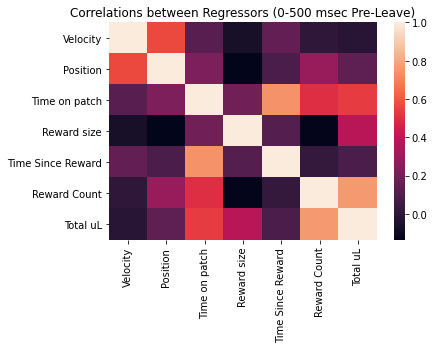

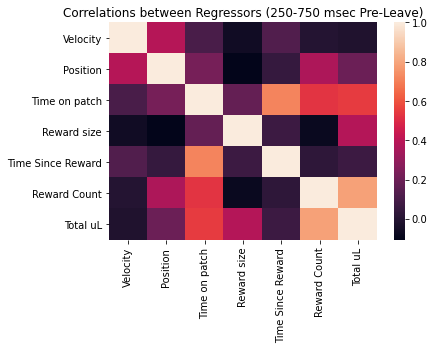

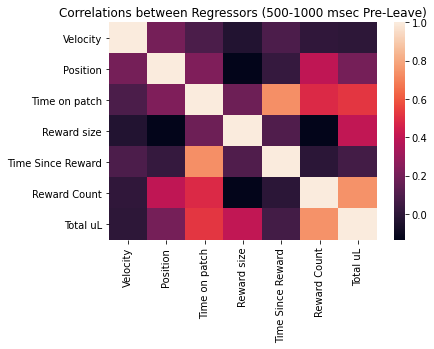

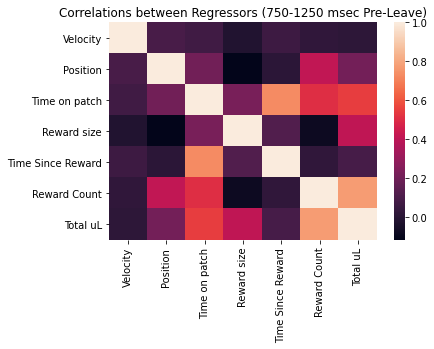

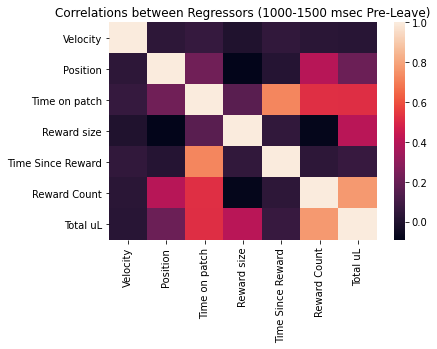

In [28]:
# look at differences over classification windows
session = "78310" 
t1_list = [0,250,500,750,1000] 
t2_list = [500,750,1000,1250,1500]
classification_windows = zip(t1_list,t2_list) 

columns = ["Classification Window","Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"]
numeric_cols = ["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"]

coeffs_df = pd.DataFrame(columns = columns)

for (t1,t2) in classification_windows:
    session_dataset = SessionDataset(data,session,t1,t2)  
    coeffs, metrics_dict = session_dataset.fit_logReg_cv(session_dataset.X_train,session_dataset.y_train,session_dataset.kfold_split) ;
    window_coeffs = np.concatenate((np.array([["%i-%i msec Pre-Leave"%(t1,t2) for i in range(5)]]).T,coeffs),axis = 1)
    i_df = pd.DataFrame(window_coeffs,columns = columns)
    i_df[numeric_cols] = i_df[numeric_cols].astype(np.float64)  
    coeffs_df = pd.concat([coeffs_df,i_df])  
    
    plt.figure()
    sns.heatmap(np.corrcoef(session_dataset.X_train,rowvar = False)) 
    plt.xticks(.5 + np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "vertical"); 
    plt.yticks(.5 + np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "horizontal"); 
    plt.title("Correlations between Regressors (%i-%i msec Pre-Leave)"%(t1,t2))
    

<Figure size 432x288 with 0 Axes>

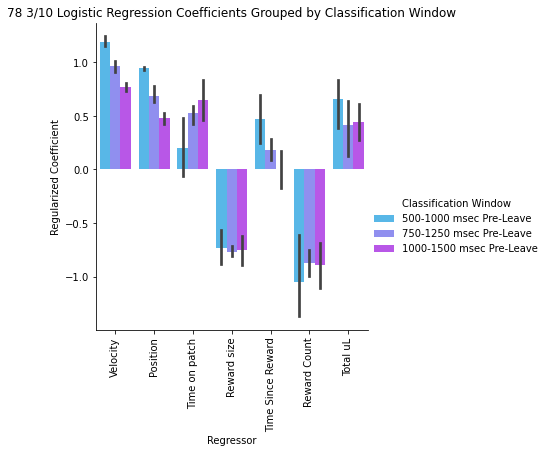

In [6]:
# visualize results
session_name = "%s %s/%s"%(session[:2],session[2],session[-2:])
vis_grouped_coeffs(coeffs_df,"Classification Window",session_name,color_palette = "cool") 


In [ ]:
# perform assay over all sessions for a mouse
mouse = "76"
mouse_days = [day for day in list(data.keys()) if mouse in day] # find all mouse days 
sorted_mouse_days = list(map(str,np.sort([int(day) for day in mouse_days]))) 

for session in sorted_mouse_days:
    session_dataset = SessionDataset(data,session,500,1000)  
    coeffs, metrics_dict = session_dataset.fit_logReg_cv(session_dataset.X_train,session_dataset.y_train,session_dataset.kfold_split) ;
    session_name = "%s %s/%s"%(session[:2],session[2],session[-2:])
    vis_coeffs(coeffs,metrics_dict,session_name)

Text(0.5, 1.0, 'Correlations between Regressors')

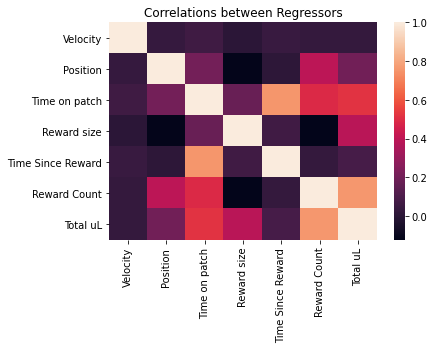

In [26]:
# np.corrcoef(session_dataset.X_train,) 
sns.heatmap(np.corrcoef(session_dataset.X_train,rowvar = False)) 
plt.xticks(.5 + np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "vertical"); 
plt.yticks(.5 + np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "horizontal"); 
plt.title("Correlations between Regressors")


## Sub-session Results

In [32]:
session = "80317" 
window_len = 50 
window_stride = 10
subsession_dataset = SubSessionDataset(data,session,500,1500,window_len,window_stride)    

coeffs_subSession = [] 
metrics_subSession = []

for i in range(len(subsession_dataset.X_train)):
    iCoeffs,iMetrics_dict = subsession_dataset.fit_logReg_cv(subsession_dataset.X_train[i],subsession_dataset.y_train[i],subsession_dataset.kfold_split[i])
    coeffs_subSession.append(iCoeffs) 
    metrics_subSession.append(iMetrics_dict) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/relational.py:356: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


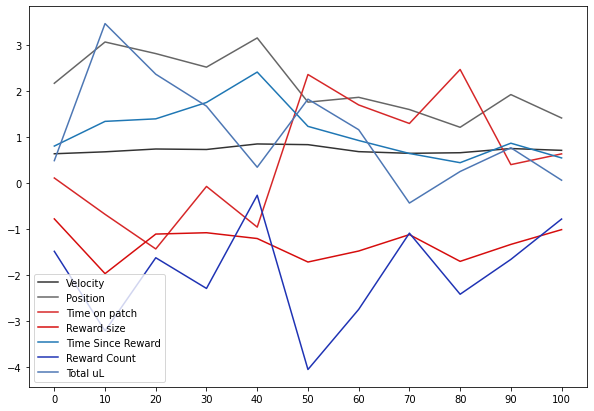

In [34]:
k1 = [.2,.2,.2] 
k2 = [.4,.4,.4] 
r1 = [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]
r2 = [0.8392156862745098, 0.05, 0.05]
b1 = [0.12156862745098039, 0.4666666666666667, 0.7058823529411765] 
b2 = [0.12156862745098039, 0.2, 0.7058823529411765] 
b3 = [0.3, 0.4666666666666667, 0.7058823529411765] 
colors = np.array([k1,k2,r1,r2,b1,b2,b3])

coeffs = pd.DataFrame(np.mean(np.array(coeffs_subSession),1))

plt.figure(figsize = (10,7))
sns.lineplot(data = coeffs,dashes = False,palette = colors,linewidth = 1.5);  

plt.xticks(np.arange(len(subsession_dataset.window_starts)),subsession_dataset.window_starts) 
plt.legend(["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


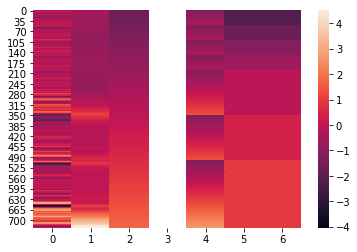

In [718]:
sns.heatmap(zscore(subsession_dataset.X_trials[38],0))